In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 3

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 3s 32ms/step - loss: 0.5433 - accuracy: 0.7541 - val_loss: 0.5319 - val_accuracy: 0.7367
Epoch 2/200
97/99 [============================>.] - ETA: 0s - loss: 0.4733 - accuracy: 0.7545
Epoch 00002: val_loss improved from inf to 0.44390, saving model to best_model_4.h5
99/99 [==============================] - 3s 29ms/step - loss: 0.4716 - accuracy: 0.7557 - val_loss: 0.4439 - val_accuracy: 0.7376
Epoch 3/200
99/99 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8045
Epoch 00003: val_loss improved from 0.44390 to 0.38459, saving model to best_model_4.h5
99/99 [==============================] - 3s 29ms/step - loss: 0.4018 - accuracy: 0.8045 - val_loss: 0.3846 - val_accuracy: 0.8441
Epoch 4/200
97/99 [============================>.] - ETA: 0s - loss: 0.3758 - accuracy: 0.8299
Epoch 00004: val_loss improved from 0.38459 to 0.37437, saving model to best_model_4.h5
99/99 [==============================] - 3s 29ms/step

Epoch 30/200
99/99 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9255
Epoch 00030: val_loss did not improve from 0.17159
99/99 [==============================] - 4s 45ms/step - loss: 0.1860 - accuracy: 0.9255 - val_loss: 0.2019 - val_accuracy: 0.9097
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9338
Epoch 00031: val_loss did not improve from 0.17159
99/99 [==============================] - 5s 46ms/step - loss: 0.1813 - accuracy: 0.9338 - val_loss: 0.3469 - val_accuracy: 0.8612
Epoch 32/200
98/99 [============================>.] - ETA: 0s - loss: 0.1895 - accuracy: 0.9273
Epoch 00032: val_loss did not improve from 0.17159
99/99 [==============================] - 5s 49ms/step - loss: 0.1899 - accuracy: 0.9271 - val_loss: 0.3292 - val_accuracy: 0.8707
Epoch 33/200
99/99 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9284
Epoch 00033: val_loss did not improve from 0.17159
99/99 [===============

99/99 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9607
Epoch 00059: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 46ms/step - loss: 0.1036 - accuracy: 0.9607 - val_loss: 0.3370 - val_accuracy: 0.8831
Epoch 60/200
98/99 [============================>.] - ETA: 0s - loss: 0.1131 - accuracy: 0.9563
Epoch 00060: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 48ms/step - loss: 0.1134 - accuracy: 0.9563 - val_loss: 0.2109 - val_accuracy: 0.9278
Epoch 61/200
99/99 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9613
Epoch 00061: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 49ms/step - loss: 0.1045 - accuracy: 0.9613 - val_loss: 0.2062 - val_accuracy: 0.9325
Epoch 62/200
99/99 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9604
Epoch 00062: val_loss did not improve from 0.15357
99/99 [============================

Epoch 89/200
99/99 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9769
Epoch 00089: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 47ms/step - loss: 0.0659 - accuracy: 0.9769 - val_loss: 0.1806 - val_accuracy: 0.9344
Epoch 90/200
99/99 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9788
Epoch 00090: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 47ms/step - loss: 0.0567 - accuracy: 0.9788 - val_loss: 0.1898 - val_accuracy: 0.9392
Epoch 91/200
98/99 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9821
Epoch 00091: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 47ms/step - loss: 0.0450 - accuracy: 0.9819 - val_loss: 0.2056 - val_accuracy: 0.9278
Epoch 92/200
99/99 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9696
Epoch 00092: val_loss did not improve from 0.15357
99/99 [===============

Epoch 119/200
99/99 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9930
Epoch 00119: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 48ms/step - loss: 0.0175 - accuracy: 0.9930 - val_loss: 0.3739 - val_accuracy: 0.9144
Epoch 120/200
98/99 [============================>.] - ETA: 0s - loss: 0.0233 - accuracy: 0.9914
Epoch 00120: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 47ms/step - loss: 0.0231 - accuracy: 0.9914 - val_loss: 0.3220 - val_accuracy: 0.9325
Epoch 121/200
99/99 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9940
Epoch 00121: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 48ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 0.2674 - val_accuracy: 0.9287
Epoch 122/200
99/99 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9924
Epoch 00122: val_loss did not improve from 0.15357
99/99 [===========

Epoch 149/200
99/99 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.0000
Epoch 00149: val_loss did not improve from 0.15357
99/99 [==============================] - 4s 45ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2600 - val_accuracy: 0.9363
Epoch 150/200
98/99 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9984
Epoch 00150: val_loss did not improve from 0.15357
99/99 [==============================] - 4s 45ms/step - loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.2610 - val_accuracy: 0.9354
Epoch 151/200
98/99 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.9981
Epoch 00151: val_loss did not improve from 0.15357
99/99 [==============================] - 5s 46ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.2768 - val_accuracy: 0.9344
Epoch 152/200
98/99 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.9821
Epoch 00152: val_loss did not improve from 0.15357
99/99 [===========

Epoch 179/200
98/99 [============================>.] - ETA: 0s - loss: 0.0077 - accuracy: 0.9974
Epoch 00179: val_loss did not improve from 0.15357
99/99 [==============================] - 4s 40ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.3110 - val_accuracy: 0.9344
Epoch 180/200
99/99 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00180: val_loss did not improve from 0.15357
99/99 [==============================] - 4s 40ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.3009 - val_accuracy: 0.9363
Epoch 181/200
99/99 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9949
Epoch 00181: val_loss did not improve from 0.15357
99/99 [==============================] - 4s 41ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.8826 - val_accuracy: 0.8698
Epoch 182/200
99/99 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9930
Epoch 00182: val_loss did not improve from 0.15357
99/99 [===========

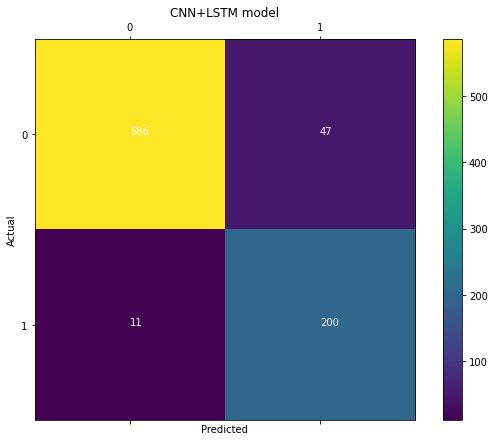

val_loss: 0.1535680890083313
test_loss: 0.1692853569984436
test_acc: 0.9312795996665955
precision: 0.8097165991902834
recall: 0.9478672985781991
specificity 0.9257503949447078
sensitivity :  0.9478672985781991
far 0.07424960505529225
frr 0.052132701421800945


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 154, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 157, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 11, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.22147858870100906)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(130)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(81, activation = 'relu')(lstm_1)
# dense_2 = tf.keras.layers.Dense(50, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_1)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_3)

# Adam
# model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.001646253038527969), metrics = ['accuracy'])
# SGD
model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.01665328009108491, momentum=0.7014797306275332), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])

# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)